In [1]:
# test cycle gan

import torch
import torch.nn as nn
import numpy as np
import itertools
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import cv2, PIL
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import operator
import csv

np.random.seed(1)

config_dic = {
    'epoch': 10,
    'n_fold': 5,
    'batch_size': 128,
    'num_workers': 3,
    'device': "cuda:5",
    'lr': 0.0002
}

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# generator & Discriminator


# 모델의 크기를 줄임
class ResnetGenerator(nn.Module):
    def __init__(self, input_ch):
        super(ResnetGenerator, self).__init__()
 
        self.init_layer = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_ch, 16, kernel_size=7, padding=0, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True))

        self.donw_sampling_layer1 = nn.Sequential(
            # down sampling
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
        )

        self.donw_sampling_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True))

        self.res_block = nn.Sequential(*[resnet_block(64) for i in range(3)])

        self.up_samplig_layer1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
        )

        self.up_samplig_layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.output_layer = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(16, input_ch, kernel_size=7, padding=0),
            nn.Tanh()
        )


    def forward(self, x):
        # x = self.model(x)
        out1 = self.init_layer(x)
        out2 = self.donw_sampling_layer1(out1)
        out3 = self.donw_sampling_layer2(out2) #
        out4 = self.res_block(out3) + out3
        out5 = self.up_samplig_layer1(out4) + out2
        out6 = self.up_samplig_layer2(out5)
        out7 = self.output_layer(out6)
        return out7

class resnet_block(nn.Module):
    def __init__(self, dim):
        super(resnet_block, self).__init__()

        _resnet_block = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
            nn.BatchNorm2d(dim)
        ]

        self.layer = nn.Sequential(*_resnet_block)

    def forward(self, x):
        out = self.layer(x) + x
        return out

class PatchGanDiscriminator(nn.Module):
    def __init__(self, input_ch):
        super(PatchGanDiscriminator, self).__init__()

        model = [
            nn.Conv2d(input_ch, 16, kernel_size=4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=True), #1
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=True), #2
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(128, input_ch, kernel_size=4, stride=1, padding=1)
        ]

        self.model = nn.Sequential(*model)
    
    def set_requires_grad(self, mode):
        for param in self.parameters():
            param.requires_grad = mode
    
    def forward(self, x):
        return self.model(x)

In [3]:
def get_img_list():
    abs_path = '/home/kji/workspace/jupyter_kji/samsumg_sem_dataset'
    
    # Dataset path
    sim_depth_path = os.path.join(abs_path, 'simulation_data/Depth')
    sim_sem_path = os.path.join(abs_path, 'simulation_data/SEM')
    
    train_path = os.path.join(abs_path, 'train')
    
    # only Test
    test_path = os.path.join(abs_path, 'test/SEM')
    
    sim_depth_img_path_dic = dict()
    for case in os.listdir(sim_depth_path):
        if not case in sim_depth_img_path_dic:
            sim_depth_img_path_dic[case] = []
        for folder in os.listdir(os.path.join(sim_depth_path, case)):
            img_list = glob.glob(os.path.join(sim_depth_path, case, folder, '*.png'))
            for img in img_list:
                sim_depth_img_path_dic[case].append(img)
                sim_depth_img_path_dic[case].append(img)

    sim_sem_img_path_dic = dict()
    for case in os.listdir(sim_sem_path):
        if not case in sim_sem_img_path_dic:
            sim_sem_img_path_dic[case] = []
        for folder in os.listdir(os.path.join(sim_sem_path, case)):
            img_list = glob.glob(os.path.join(sim_sem_path, case, folder, '*.png'))
            sim_sem_img_path_dic[case].extend(img_list)
    
    train_avg_depth = dict()
    with open(os.path.join(train_path, "average_depth.csv"), 'r') as csvfile:
        temp = csv.reader(csvfile)
        for idx, line in enumerate(temp):
            if idx > 0:
                depth_key, site_key = line[0].split('_site')
                depth_key = depth_key.replace("d", "D")
                site_key = "site" + site_key
                if not depth_key in train_avg_depth:
                    train_avg_depth[depth_key] = dict()

                train_avg_depth[depth_key][site_key] = float(line[1])
    
    train_img_path_dic = dict()
    for depth in os.listdir(os.path.join(train_path, "SEM")):
        if not depth in train_img_path_dic:
            train_img_path_dic[depth] = []
        for site in os.listdir(os.path.join(train_path, "SEM", depth)):
            img_list = glob.glob(os.path.join(train_path, "SEM", depth, site, "*.png"))
            train_img_path_dic[depth].extend([[temp_img, train_avg_depth[depth][site]]for temp_img in img_list])
    
    test_img_path_list = glob.glob(os.path.join(test_path, "*.png"))
    
    result_dic = dict()
    result_dic['sim'] = dict()
    result_dic['sim']['sem'] = sim_sem_img_path_dic
    result_dic['sim']['depth'] = sim_depth_img_path_dic
    result_dic['train'] = train_img_path_dic
    result_dic['test'] = np.array(test_img_path_list)
    result_dic['train_avg_depth'] = train_avg_depth
    
    return result_dic

result_dic = get_img_list()

In [4]:
## create k-fold
def K_fold(k, result_dic):
    # case1 case2 case3 case4
    # sim_sem(173,304) _itr0,1 <-> sem_depth(86,652) * 2
    def ret_chunk(path_dic):
        case_len_list = list(map(len, [path_dic[case] for case in path_dic])) # [43326, 43326, 43326, 43326] => [ [(0,11111) (11111,22222) (22222,33333) (33333,None)]
        def ret_slice_indices(k, size):
            chunk_size = int(size / k)
            _list = []
            for i in range(k):
                if i == k-1:
                    _list.append(slice(i * chunk_size, None))
                else:
                    _list.append(slice(i * chunk_size, (i + 1) * chunk_size))
            return _list

        case_list = [path_dic[case] for case in path_dic]
        slice_indice = list(map(ret_slice_indices, [k]*k, case_len_list))
        chunk_list = [[c[s] for s in slice_list] for c, slice_list in zip(case_list, slice_indice)]

        merge_chunk = [[] for i in range(k)]
        for c in chunk_list:
            for i, chunk in enumerate(c):
                merge_chunk[i].extend(chunk)

        return merge_chunk

    sim_sem_chunk = ret_chunk(result_dic['sim']['sem'])
    sem_depth_chunk = ret_chunk(result_dic['sim']['depth'])
    train_chunk = ret_chunk(result_dic['train'])

    chunk_dic = dict()
    chunk_dic['sim_sem'] = sim_sem_chunk
    chunk_dic['sim_depth'] = sem_depth_chunk
    chunk_dic['train'] = train_chunk

    return chunk_dic

chunk_dic = K_fold(config_dic['n_fold'], result_dic)

In [5]:
class sim_dataset(Dataset):
    def __init__(self, sem_data_list, depth_data_list, transform=None):
        super(sim_dataset, self).__init__()
        self.sem_data_list = sem_data_list
        self.depth_data_list = depth_data_list
        self.transform = transform

    def __getitem__(self, idx):
        sem_img = PIL.Image.open(self.sem_data_list[idx]).convert("L")
        depth_img = PIL.Image.open(self.depth_data_list[idx]).convert("L")
        if self.transform:
            depth_img = self.transform(depth_img)
            sem_img = self.transform(sem_img)
            
        sem_img = np.array(sem_img)
        sem_img = sem_img.reshape(1, *sem_img.shape)
        depth_img = np.array(depth_img)
        depth_img = depth_img.reshape(1, *depth_img.shape)
        
        if not isinstance(sem_img, torch.Tensor):
            sem_img = torch.Tensor(sem_img)
            
        if not isinstance(depth_img, torch.Tensor):
            depth_img = torch.Tensor(depth_img)
        
        return (sem_img /255.0).type(torch.float32), (depth_img/255.0).type(torch.float32)

    def __len__(self):
        return len(self.sem_data_list)
#         return 200

horizon_transform = transforms.RandomHorizontalFlip(1.0)
rotate_transform = transforms.RandomRotation((180,180))
vertical_transform = transforms.RandomVerticalFlip(1.0)
color11_transform = transforms.ColorJitter(brightness = [0.8, 0.8])
color12_transform = transforms.ColorJitter(brightness = [0.9, 0.9])
transform = None

transform_list = [horizon_transform, rotate_transform, color11_transform, color12_transform, vertical_transform]

In [6]:
dataset_list = []
for i in range(config_dic['n_fold']): # n_fold
    sem_train_data_list = []
    sem_valid_data_list = []
    depth_train_data_list = []
    depth_valid_data_list = []
    for j in range(config_dic['n_fold']):
        if i == j:
            sem_valid_data_list.extend(chunk_dic['sim_sem'][j])
            depth_valid_data_list.extend(chunk_dic['sim_depth'][j])
        else:
            sem_train_data_list.extend(chunk_dic['sim_sem'][j])
            depth_train_data_list.extend(chunk_dic['sim_depth'][j])

    dataset_list.append([sem_train_data_list, sem_valid_data_list, depth_train_data_list, depth_valid_data_list])

temp = []

for dataset in dataset_list:
    dataset_transform = []
    train_dataset = sim_dataset(sem_data_list=dataset[0],
                                depth_data_list=dataset[2],
                                transform=transform)
    valid_dataset = sim_dataset(sem_data_list=dataset[1],
                                depth_data_list=dataset[3],
                                transform=transform)
    dataset_transform.append([train_dataset, valid_dataset])
    print(len(train_dataset))
    for _transform in transform_list:
        train_dataset = sim_dataset(sem_data_list=dataset[0],
                                depth_data_list=dataset[2],
                                transform=_transform)
        valid_dataset = sim_dataset(sem_data_list=dataset[1],
                                    depth_data_list=dataset[3],
                                    transform=transform)
        dataset_transform.append([train_dataset, valid_dataset])
#         print(len(train_dataset))
    
    train_dataset = dataset_transform[0][0] + dataset_transform[1][0] + dataset_transform[2][0] + dataset_transform[3][0] + dataset_transform[4][0] + dataset_transform[5][0]
    valid_dataset = dataset_transform[0][1] + dataset_transform[1][1] + dataset_transform[2][1] + dataset_transform[3][1] + dataset_transform[4][1] + dataset_transform[5][1]
    temp.append([train_dataset, valid_dataset])


folds_dataloader = [] # k개의 datalodaer를 저장함
for fold in temp:
    train_loader = DataLoader(fold[0], batch_size=config_dic['batch_size'], shuffle=True, num_workers=config_dic['num_workers'])
    valid_loader = DataLoader(fold[1], batch_size=config_dic['batch_size'], shuffle=False, num_workers=config_dic['num_workers'])

    folds_dataloader.append([train_loader, valid_loader])

138644
138644
138644
138644
138640


In [7]:
class GANLoss(nn.Module):
    def __init__(self):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(1.0))
        self.register_buffer('fake_label', torch.tensor(0.0))
        # self.device = device
        self.loss = nn.MSELoss()

    def __call__(self, prediction, target_is_real):

        if target_is_real:
            target_tensor = self.real_label#.to(self.device)
        else:
            target_tensor = self.fake_label#.to(self.device)

        target_tensor = target_tensor.expand_as(prediction)

        loss = self.loss(prediction, target_tensor)

        return loss


def style_gan_train(data, model_dic, optimizer, criterion, schedular, device):
    
    image_a = data['A']
    image_b = data['B']
    
    net_gen_A = model_dic['gen_A']
    net_gen_B = model_dic['gen_B']
    net_dis_A = model_dic['dis_A']
    net_dis_B = model_dic['dis_B']
    
    optimizer_G = optimizer['G']
    optimizer_D = optimizer['D']
    
    schedular_G = schedular['G']
    schedular_D = schedular['D']
    
    criterion_cycle = criterion['cycle']
    criterion_Idt = criterion['idt']
    criterion_gan = criterion['gan']
    
    # device select
    real_A = image_a.to(device,non_blocking=True) #갈색말
    real_B = image_b.to(device,non_blocking=True) #얼룩말
    
    net_gen_A.to(device,non_blocking=True)
    net_gen_A.train()
    net_gen_B.to(device,non_blocking=True) 
    net_gen_B.train()
    net_dis_A.to(device,non_blocking=True) 
    net_dis_A.train()
    net_dis_B.to(device,non_blocking=True) 
    net_dis_B.train()
    
    criterion_cycle.to(device,non_blocking=True)  
    criterion_Idt.to(device,non_blocking=True) 
    criterion_gan.to(device,non_blocking=True) 
    
    
    # forward
    fake_B = net_gen_A(real_A) # G_A(A) A to B
    rec_A = net_gen_B(fake_B) # G_B(G_A(A)) B to A reconstruct

    fake_A = net_gen_B(real_B) # G_B(B) B to A
    rec_B = net_gen_A(fake_A) # G_A(G_B(B)) A to B
    
    net_dis_A.set_requires_grad(False)
    net_dis_B.set_requires_grad(False)
    
    optimizer_G.zero_grad()

    lambda_idt = 0.5
    lambda_A = 10.0
    lambda_B = 10.0
    
    idt_A = net_gen_A(real_B)
    loss_idt_A = criterion_Idt(idt_A, real_B) * lambda_B * lambda_idt

    idt_B = net_gen_B(real_A)
    loss_idt_B = criterion_Idt(idt_B, real_A) * lambda_A * lambda_idt

    loss_G_A = criterion_gan(net_dis_A(fake_B), True)
    loss_G_B = criterion_gan(net_dis_B(fake_A), True)

    loss_cycle_A = criterion_cycle(rec_A, real_A) * lambda_A #cycle consistency loss
    loss_cycle_B = criterion_cycle(rec_B, real_B) * lambda_B #cycle consistency loss

    loss_Gen = loss_G_A + loss_G_B + loss_cycle_A + loss_cycle_B + loss_idt_B + loss_idt_A
    loss_Gen.backward()

#     print(loss_Gen.item())
    # optimizer Generator step
    optimizer_G.step()
    
    # discriminator train
    net_dis_A.set_requires_grad(True)
    net_dis_B.set_requires_grad(True)
    
    optimizer_D.zero_grad()

    #backward Dis A
    pred_real = net_dis_A(real_B)
    loss_D_real = criterion_gan(pred_real, True)
    # Fake
    pred_fake = net_dis_A(fake_B.detach())
    loss_D_fake = criterion_gan(pred_fake, False)
    # Combined loss and calculate gradients
    loss_D_A = (loss_D_real + loss_D_fake) * 0.5
    loss_D_A.backward()

    #backward Dis B
    pred_real = net_dis_B(real_A)
    loss_D_real = criterion_gan(pred_real, True)
    # Fake
    pred_fake = net_dis_B(fake_A.detach())
    loss_D_fake = criterion_gan(pred_fake, False)
    # Combined loss and calculate gradients
    loss_D_B = (loss_D_real + loss_D_fake) * 0.5
    loss_D_B.backward()

    optimizer_D.step()
    
    loss_dic = {'gen':loss_Gen.item(),
               'dis_a':loss_D_A.item(),
               'dis_b':loss_D_B.item()}
    
    inference_image = {
        'real_a':real_A,
        'real_b':real_B,
        'atob_fake':fake_B,
        'btoa_fake':fake_A,
        'rec_a':rec_A,
        'rec_b':rec_B
    }
    
    def tensortonp(tensor):
        return tensor.detach().cpu().numpy()
    
    return loss_dic, {key:tensortonp(inference_image[key]) for key in inference_image.keys()}

In [8]:
def validation(model, val_loader, epoch, device, n_fold):
    model.eval()
    mse_criterion = nn.MSELoss().to(device)

    with torch.no_grad():
        valid_loss = []
        depth_mean_list = []
        for sem_img, depth_img in tqdm(val_loader):
            sem_img = sem_img.to(device)
            depth_img = depth_img.to(device)
            
            pred = model(sem_img)
            pred = (pred * 255).type(torch.int8).float()
            
            np_depth = (depth_img * 255).type(torch.int8).float().cpu().numpy()
            np_pred = pred.cpu().numpy()
            
            true = (depth_img * 255).type(torch.int8).float()
            mse_loss = torch.sqrt(mse_criterion(pred, true))
            
            valid_loss.append(mse_loss.item())
        rmse_loss = np.mean(valid_loss)

    return rmse_loss

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import copy
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

def train(train_lodaer, val_loader, epochs, device, n_fold):
    
    model_dic = {'gen_A':ResnetGenerator(1),
                 'gen_B':ResnetGenerator(1),
                 'dis_A':PatchGanDiscriminator(1),
                 'dis_B':PatchGanDiscriminator(1)}
    
    criterion = {'cycle':nn.L1Loss(),
                 'idt':nn.L1Loss(),
                 'gan':GANLoss()}
    
    
    optimizer = {'G':torch.optim.Adam(itertools.chain(model_dic['gen_A'].parameters(), model_dic['gen_B'].parameters()), 
                                   lr=config_dic['lr'], 
                                   betas=(0.5, 0.999)),
                'D':torch.optim.Adam(itertools.chain(model_dic['dis_A'].parameters(), model_dic['dis_B'].parameters()), 
                                   lr=config_dic['lr'],
                                   betas=(0.5, 0.999))}
    
    schedular = {'G':torch.optim.lr_scheduler.LambdaLR(optimizer['G'], lr_lambda=lambda epoch: 0.95 ** epoch),
                'D':torch.optim.lr_scheduler.LambdaLR(optimizer['D'], lr_lambda=lambda epoch: 0.95 ** epoch)}
    
    best_rmse_loss = 9999
    best_model = model_dic
    best_epoch = 0
    best_train_loss = 9999
    
    groups = {
        'log_loss': ['gen', 'd_a', 'd_b'],
        'step_loss': ['gen_step', 'd_a_step', 'd_b_step'],
        'rmse_loss': ['valid']
    }
    plot_losses = PlotLosses(groups=groups, outputs=[MatplotlibPlot()])
    plot_losses.logger.step_names['step_loss'] = "step_size" # edit x_label
    plot_losses.update(logs={
            'gen': 0,
            'd_a': 0,
            'd_b': 0,
            'valid':0
        },
                      current_step=0)
    for epoch in range(epochs):
        epoch_loss =[]
        
        for step_i, (sem_img, depth_img) in enumerate(tqdm(train_lodaer)):
            
            data_dic = {'A':sem_img,
                       'B':depth_img}
            
            loss_dic, image_dic = style_gan_train(data=data_dic,
                                                           model_dic=model_dic,
                                                           optimizer=optimizer,
                                                           criterion=criterion,
                                                           schedular=schedular,
                                                           device=device)
            
            epoch_loss.append([loss_dic['gen'] , loss_dic['dis_a'], loss_dic['dis_b']])
            
            plot_losses.update(logs={
                'gen_step': loss_dic['gen'],
                'd_a_step': loss_dic['dis_a'],
                'd_b_step': loss_dic['dis_b']
            },
                              current_step=step_i)
        
            plot_losses.send()
        if epoch == 0:
            del plot_losses.logger.log_history['gen']
            del plot_losses.logger.log_history['d_a']
            del plot_losses.logger.log_history['d_b']
            del plot_losses.logger.log_history['valid']
        
        rmse_loss = validation(model_dic['gen_A'], val_loader, epoch, device, n_fold)
            
        epoch_mean = np.mean(epoch_loss, axis=0)
        plot_losses.update(logs={
            'gen': epoch_mean[0],
            'd_a': epoch_mean[1],
            'd_b': epoch_mean[2],
            'valid': rmse_loss
        },
                           current_step=epoch)
        
        plot_losses.send()
        
        del plot_losses.logger.log_history['gen_step']
        del plot_losses.logger.log_history['d_a_step']
        del plot_losses.logger.log_history['d_b_step']
       
        
        if rmse_loss < best_rmse_loss:
            best_model = copy.deepcopy(model_dic)
            best_epoch = epoch
            best_rmse_loss = rmse_loss
            best_train_loss = epoch_mean

    print(f"best model epoch-{best_epoch} / rmse:{best_rmse_loss}/ train_loss:{best_train_loss}")
    return best_model, best_epoch, best_rmse_loss, best_train_loss

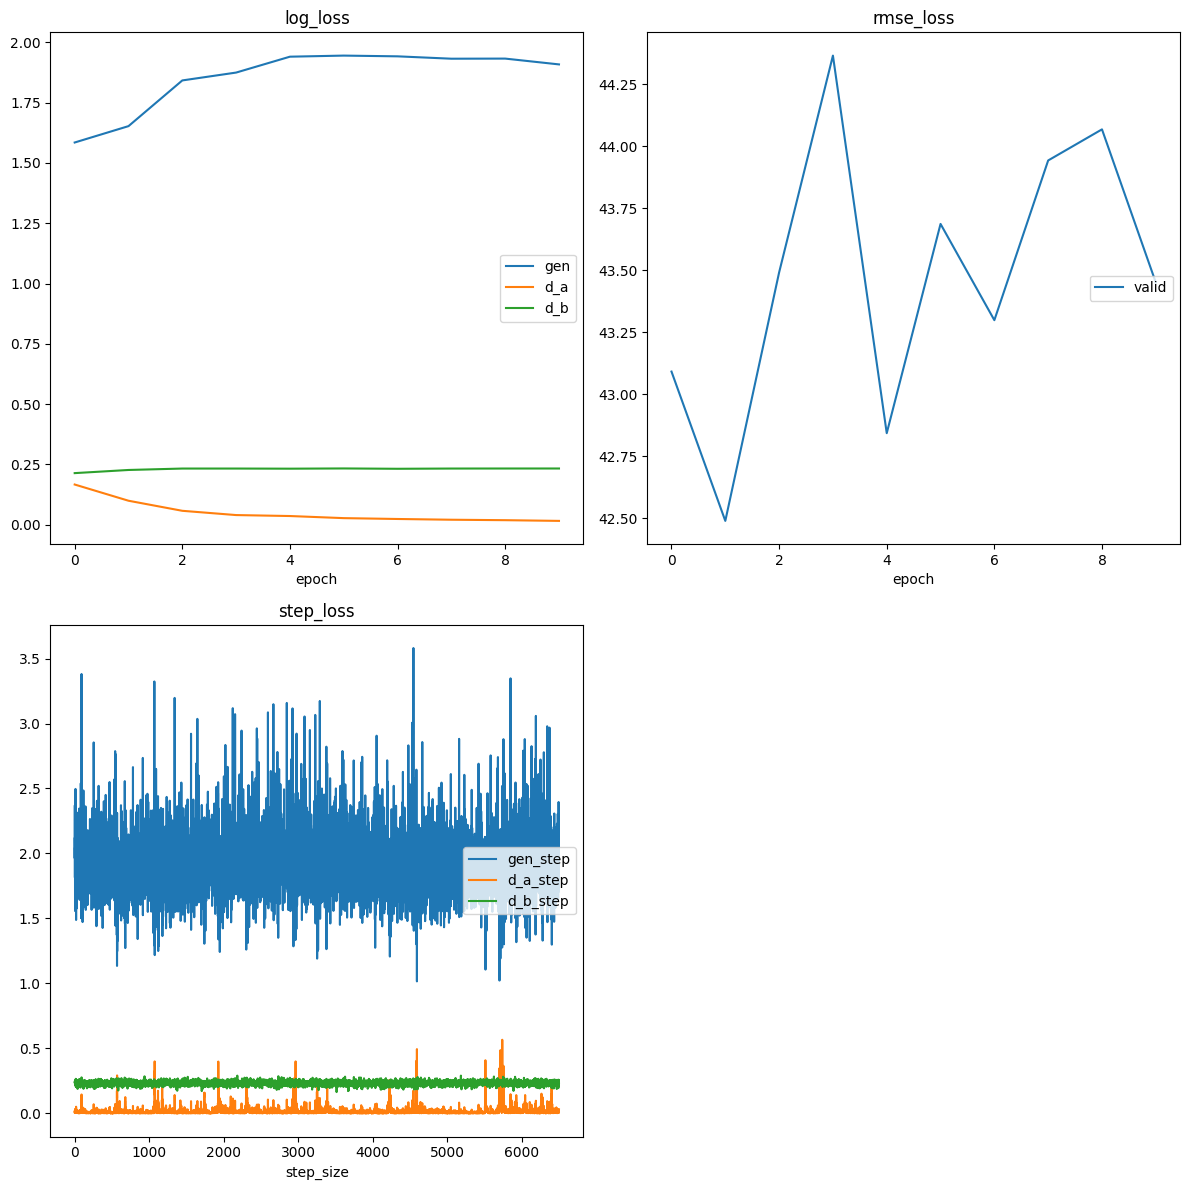

best model epoch-1 / rmse:42.48993503511869/ train_loss:[1.65238381 0.09966041 0.22715223]


In [10]:
best_model_list = []
for fold_i, data_loaders in enumerate(folds_dataloader):
    print("train",len(data_loaders[0]),"valid",len(data_loaders[1]))
    best_model,best_epoch, best_rmse_loss, best_train_losss = train(data_loaders[0], 
                       data_loaders[1], 10, config_dic['device'], fold_i)
    best_model_list.append([best_model,best_epoch, best_rmse_loss, best_train_losss])
    if fold_i == 0:
        break

In [14]:
torch.save(best_model_list[0][0]['gen_A'], './cycle_gan_221209_GA.pt')
torch.save(best_model_list[0][0]['gen_B'], './cycle_gan_221209_GB.pt')

In [13]:
best_model_list[0][0]

{'gen_A': ResnetGenerator(
   (init_layer): Sequential(
     (0): ReflectionPad2d((3, 3, 3, 3))
     (1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
     (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): ReLU(inplace=True)
   )
   (donw_sampling_layer1): Sequential(
     (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
   )
   (donw_sampling_layer2): Sequential(
     (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
   )
   (res_block): Sequential(
     (0): resnet_block(
       (layer): Sequential(
         (0): ReflectionPad2d((1, 1, 1, 1))
         (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
         (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, 